# V928 Tau - Fuzzy Disk

In this notebook we take the output of the stellar variation notebook and model the eclipse. We do this using the <strong>pyPplusS</strong> package designed by Rein & Odir 2019. We make the assumption that the two components of the binary are identical and thus that the deblended light curve just doubles the fluctuations about 1. Here we test the fuzzy disk model.

In [1]:
import emcee
import logging
import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from Code import mcmc, eclipse

%matplotlib inline

## Load the Data

In [2]:
time, flux_b, flux, error = eclipse.load_data('data/photometry/eclipse_lightcurve.txt')

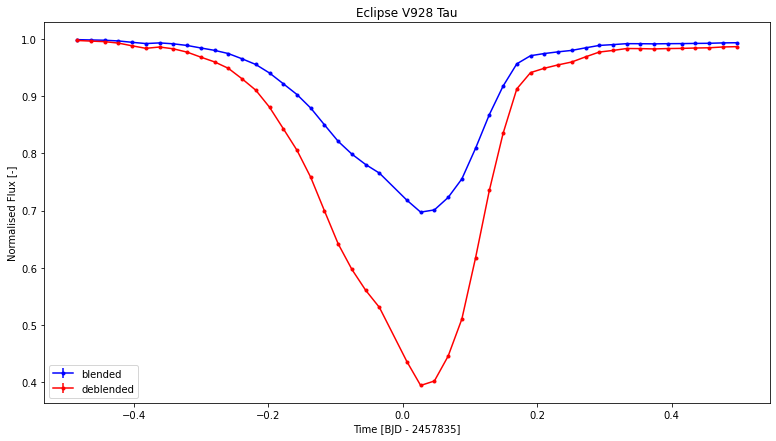

In [3]:
plt.figure(figsize=(13, 7))
plt.title('Eclipse V928 Tau')
plt.xlabel('Time [BJD - 2457835]')
plt.ylabel('Normalised Flux [-]')
plt.errorbar(time, flux_b, yerr=error, fmt='.', color='b', ls='-', label='blended')
plt.errorbar(time, flux, yerr=error, fmt='.', color='r', ls='-', label='deblended')
plt.legend()
plt.show()

## Model Set-up

This takes the <strong>disk_model()</strong> function from <strong>eclipse_functions</strong>, and creates sub-functions for the fuzzy disk model.

In [4]:
# model functions
fuzzy_disk       = eclipse.disk_model
fuzzy_prior       = eclipse.disk_prior

In [5]:
# Bounds of the parameters (t = tilt, T = tau, rest as above)
rl, ru = (0., 10.)
bl, bu = (-10.,10.)
il, iu = (0., np.pi/2.)
tl, tu = (0., np.pi/2.)
vl, vu = (5.9, 20.)
xl, xu = (-10.,10.)
Tl, Tu = (0.,1.)

## Fuzzy Disk

The fuzzy disk is a two component disk model which is ended to have an opaque centre (as above) and then an extended edge that is expected to be relatively transparent.

In [ ]:
# setting up labels, units and bounds for the fuzzy disk
lbls_fd = ['disk radius', 'edge thickness', 'impact parameter', 'inclination', 'tilt', 
           'velocity', 'time shift', 'disk opacity', 'edge opacity']
units_fd = ['R*', 'R*', 'R*', 'deg', 'deg', 'R*/day', 'day', '-', '-']
bounds_fd = [(rl, ru/2.), (rl, ru/2.), (bl/2., bu/2.), (iu/2., iu), (tl, tu), (vl, vu/2.), 
             (-0.5, 0.5), (Tu/2., Tu), (Tl, Tu/2.)]

# setting up intial guess for the fuzzy disk
args_fd = (9, 1000, bounds_fd)
p0_fd = eclipse.useful_p0(mcmc.bounded_p0, args_fd, fuzzy_disk, time, True, 5)


  1%|          | 7/1000 [00:00<00:14, 68.77it/s]

round 1 from 0 to 57 (max = 1000)


  1%|          | 8/1000 [00:00<00:13, 71.86it/s]

round 2 from 57 to 129 (max = 1000)


  1%|          | 7/1000 [00:00<00:15, 63.96it/s]

round 3 from 129 to 194 (max = 1000)


  1%|          | 6/1000 [00:00<00:17, 57.84it/s]

round 4 from 194 to 252 (max = 1000)


  1%|          | 8/1000 [00:00<00:13, 76.31it/s]

round 5 from 252 to 336 (max = 1000)


 96%|█████████▋| 964/1000 [00:13<00:00, 72.91it/s]

In [ ]:
mcmc.plot_hist(p0_fd, lbls_fd)

In [ ]:
# mcmc parameters for the fuzzy disk
be_fd = 'models/mcmc_backends/fuzzy_disk_new.h5'
mcmc_args_fd = (time, flux, error, fuzzy_disk, fuzzy_prior)
BE_fd = emcee.backends.HDFBackend(be_fd)

# run mcmc for the fuzzy disk
#p_fd, sampler_fd = mcmc.run_mcmc(*mcmc_args_fd, p0_fd, 3500, reset=False, savename=be_fd)

# load mcmc for the fuzzy disk
sampler_fd = emcee.EnsembleSampler(1000, 9, mcmc.lnprob, args=mcmc_args_fd, backend=BE_fd)

In [ ]:
# plot the walkers for the fuzzy disk
mcmc.plot_walkers(sampler_fd, lbls=lbls_fd)

In [ ]:
# plot the triangle for the fuzzy disk
mcmc.plot_triangle(sampler_fd, lbls=lbls_fd)

There are quite a couple of splits here: disk radius, velocity, disk and edge opacity. We start as for the opaque disk with the velocity split.

### Extracting Solutions (Velocity) for the Fuzzy Disk

Here we extract solutions with velocities below and above 8.5 $R_* \, \mathrm{day}^{-1}$.

In [ ]:
# extracting disk opacity radius for the fuzzy disk
v_names_fd = ['slow', 'fast']
vl_fd, vh_fd,  = mcmc.extract_solutions(sampler_fd, [5, 5], [(0., 8.5), (8.5, 20.)],
                                                0, lbls_fd, v_names_fd)

1) Opaque Disk solutions: have lower velocities and Disk radii (which seems obvious)

2) Translucent Disk solutions: have higher velocities smaller edge thicknesses and larger disk radii (as if just a larger translucent disk)

#### Low Velocity Solutions for the Fuzzy Disk

In [ ]:
# plot the low velocity walkers for the fuzzy disk
mcmc.plot_walkers(vl_fd, 0, lbls_fd)

In [ ]:
# plot the low velocity triangle for the fuzzy disk
mcmc.plot_triangle(vl_fd, 0, lbls_fd)

Clearly one solution.

In [ ]:
# determine burn-in for the low velocity solutions for the fuzzy disk
cut_vl_fd = 1000

# carry out statistics for the low velocity solutions for the fuzzy disk
stats_vl_fd, pb_vl_fd = mcmc.stats(vl_fd, cut=cut_vl_fd)

# plot the samples for the low velocity solutions for the fuzzy disk
_ = mcmc.plot_samples(time, flux, error, [fuzzy_disk], [vl_fd], ['low velocity fuzzy disk'], cut_vl_fd, 500, 
                 best_fit=True, dt=3002, residual_lims=(-0.08,0.08))

In [ ]:
# print the best fit parameters for the low velocity low disk radii solutions for the translucent disk
mcmc.print_parameters(pb_vl_fd, lbls_fd, units_fd)

#### High Velocity Solutions for the Fuzzy Disk

In [ ]:
# plot the high velocity walkers for the fuzzy disk
mcmc.plot_walkers(vh_fd, 0, lbls_fd)

In [ ]:
# plot the high velocity triangle for the fuzzy disk
mcmc.plot_triangle(vh_fd, lbls=lbls_fd)

There is quite a spread, but let's take a look at the edge opacity. We see a large distribution centred around ~ 0.20, and then some solution with very high opacity. The disk opacity peaks at ~ 0.65. We are interested in a fuzzy disk, i.e. thicker centre and thinner edge, so let's take the solutions that are above and below 0.5 in edge opacity.

### Extracting Solutions (Edge Opacity) for the High Velocity Fuzzy Disk

Here we extract the solutions with an edge opacity above and below 0.5.

In [ ]:
# extracting edge opacity for the high velocity fuzzy disk
eo_names_fd = ['transparent', 'translucent']
eol_fd, eoh_fd,  = mcmc.extract_solutions(vh_fd, [-1, -1], [(0., .5), (.5, 1.)],
                                                0, lbls_fd, eo_names_fd)

#### Transparent Solutions for the High Velocity Fuzzy Disk

In [ ]:
# plot the transparent walkers for the high velocity fuzzy disk
mcmc.plot_walkers(eol_fd, 0, lbls_fd)

In [ ]:
# plot the transparent triangle for the high velocity fuzzy disk
mcmc.plot_triangle(eol_fd, 0, lbls_fd)

Note that there is just one solution, but note the very few number of walkers (51/1000).

In [ ]:
# determine burn-in for the transparent solutions for the high velocity fuzzy disk
cut_eol_fd = 1000

# carry out statistics for the transparent solutions for the high velocity fuzzy disk
stats_eol_fd, pb_eol_fd = mcmc.stats(eol_fd, cut=cut_eol_fd)

# plot the samples for the transparent solutions for the high velocity fuzzy disk
_ = mcmc.plot_samples(time, flux, error, [fuzzy_disk], [eol_fd], ['transparent fuzzy disk'], cut_eol_fd, 500, 
                 best_fit=True, dt=3002, residual_lims=(-0.08,0.08))

In [ ]:
# print the best fit parameters for the low velocity low disk radii solutions for the translucent disk
mcmc.print_parameters(pb_vl_fd, lbls_fd, units_fd)

#### Translucent Solutions for the High Velocity Fuzzy Disk

In [ ]:
# plot the translucent walkers for the high velocity fuzzy disk 
mcmc.plot_walkers(eoh_fd, 0, lbls_fd)

In [ ]:
# plot the translucent triangle for the high velocity fuzzy disk
mcmc.plot_triangle(eoh_fd, 0, lbls_fd)

We see several solutions. We see peaks in so we try radius########

### Extract Solutions (Disk Opacity) for the High Velocity Translucent Fuzzy Disk

In [ ]:
# extracting disk opacity for the high velocity translucent fuzzy disk
do_names_fd = ['low', 'mid', 'high']
dol_fd, dom_fd, doh_fd = mcmc.extract_solutions(eoh_fd, [-2, -2, -2], [(0, 0.6), (0.6, 0.7), (0.7, 1)],
                                                0, lbls_fd, do_names_fd)

#### Transparent Inner Disk Solutions for the High Velocity Translucent Fuzzy Disk

In [ ]:
# plot the transparent inner disk solutions for the high velocity translucent fuzzy disk
mcmc.plot_walkers(dol_fd, 0, lbls_fd)

In [ ]:
# plot the transparent inner disk triangle for the high velocity translucent fuzzy disk
mcmc.plot_triangle(dol_fd, 0, lbls_fd)

This keeps the same distribution so move on.

#### Translucent Inner Disk Solutions for the High Velocity Translucent Fuzzy Disk

In [ ]:
# plot the translucent inner disk walkers for the translucent fuzzy disk
mcmc.plot_walkers(dom_fd, 0, lbls_fd)

In [ ]:
# plot the translucent inner disk triangle for the translucent fuzzy disk
mcmc.plot_triangle(dom_fd, 0, lbls_fd)

Clearly one solution (note the small number of walkers).

In [ ]:
# determine burn-in for the translucent inner disk solutions for the high velocity translucent fuzzy disk
cut_dom_fd = 1000

# carry out statistics for the translucent inner disk solutions for the high velocity translucent fuzzy disk
stats_dom_fd, pb_dom_fd = mcmc.stats(dom_fd, cut=cut_dom_fd)

# plot the samples for the translucent inner disk solutions for the high velocity translucent fuzzy disk
_ = mcmc.plot_samples(time, flux, error, [fuzzy_disk], [dom_fd], ['translucent inner disk fuzzy disk'], cut_dom_fd, 500, 
                 best_fit=True, dt=3002, residual_lims=(-0.08,0.08))

In [ ]:
# print best fit parameters for the translucent inner disk solutions for the high velocity translucent fuzzy disk
mcmc.print_parameters(pb_dom_fd, lbls_fd, units_fd)

#### Opaque Inner Disk Solutions for the High Velocity Translucent Fuzzy Disk

In [ ]:
# plot the opaque inner disk walkers for the opaque fuzzy disk
mcmc.plot_walkers(doh_fd, 0, lbls_fd)

In [ ]:
# plot the opaque inner disk triangle for the opaque fuzzy disk
mcmc.plot_triangle(doh_fd, 0, lbls_fd)

100%|██████████| 500/500 [01:28<00:00,  5.64it/s]


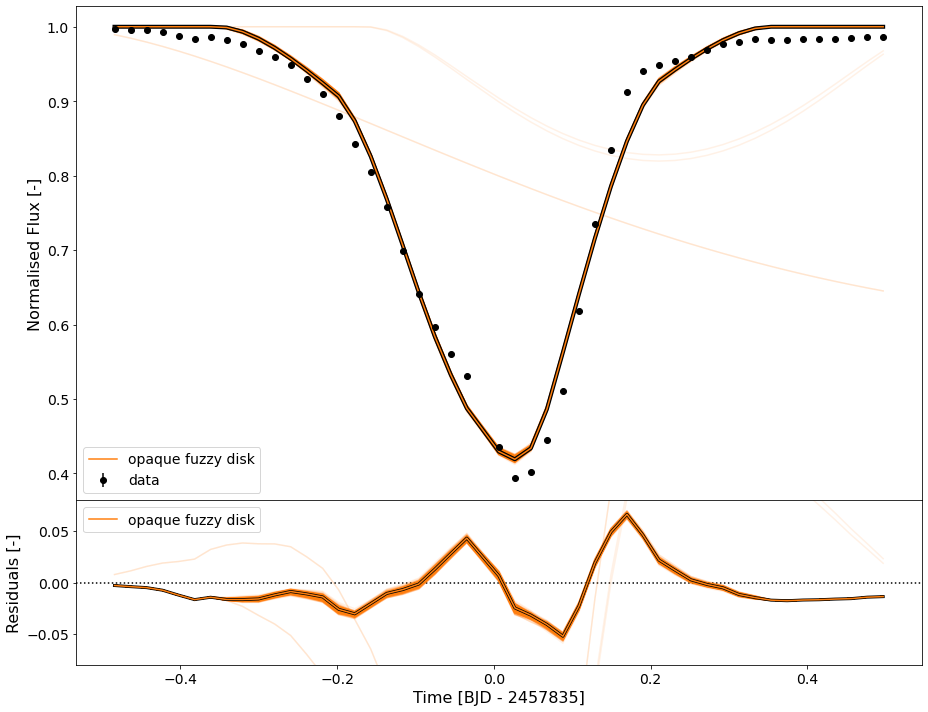

In [74]:
# determine burn-in for the high velocity solutions for the fuzzy disk
cut_vh_fd = 350

# carry out statistics for the high velocity solutions for the fuzzy disk
stats_vh_fd, pb_vh_fd = mcmc.stats(vh_fd, cut=cut_vh_fd)

# plot the samples for the high velocity solutions for the fuzzy disk
_ = mcmc.plot_samples(time, flux, error, [fuzzy_disk], [vh_fd], ['high velocity fuzzy disk'], cut_vh_fd, 500, 
                 best_fit=True, dt=3002, residual_lims=(-0.08,0.08))

In [75]:
# print the best-fit parameters for the translucent solutions for the fuzzy disk
mcmc.print_parameters(pb_doh_fd, lbls_fd, units_fd)

disk radius        =     +1.001669     [R*]
edge thickness     =     +1.781314     [R*]
impact parameter   =     -0.317056     [R*]
inclination        =     +61.05232     [deg]
tilt               =     +43.68275     [deg]
velocity           =     +8.179997     [R*/day]
time shift         =     +0.017907     [day]
disk opacity       =     +0.996586     [-]
edge opacity       =     +0.162823     [-]


#### Translucent Solutions for the Fuzzy Disk

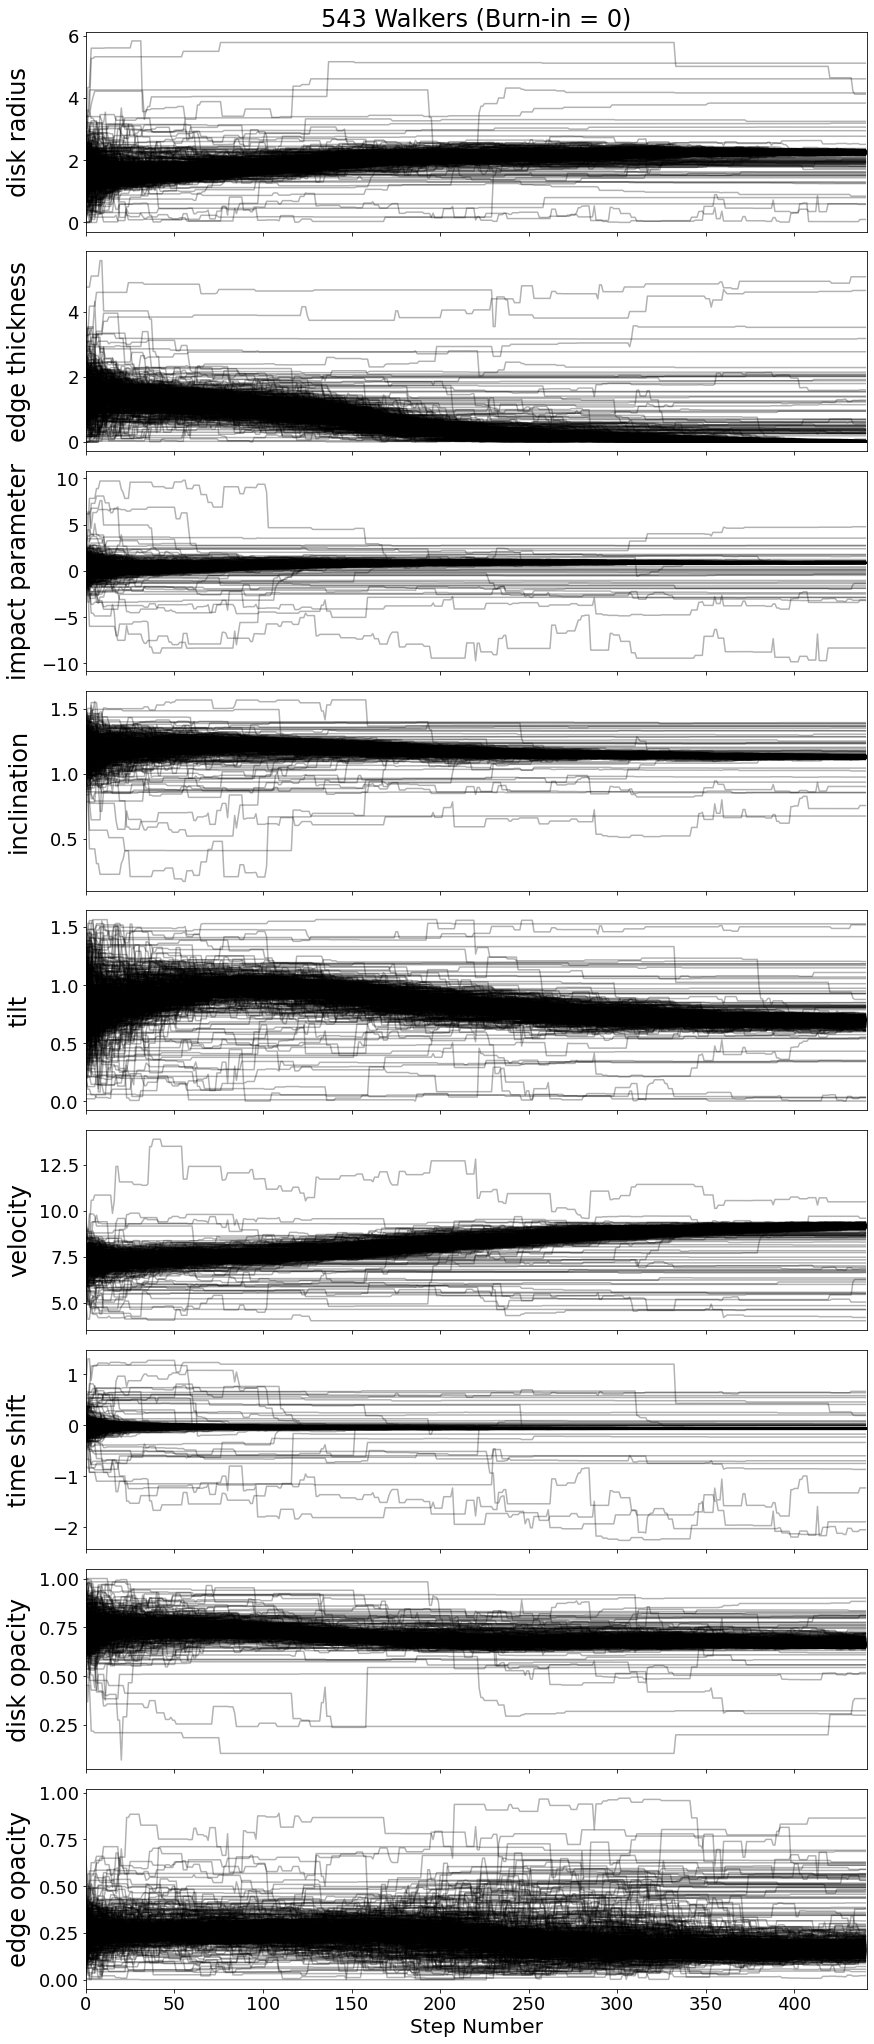

In [76]:
# plot the translucent walkers for the fuzzy disk
mcmc.plot_walkers(dol_fd, 0, lbls_fd)

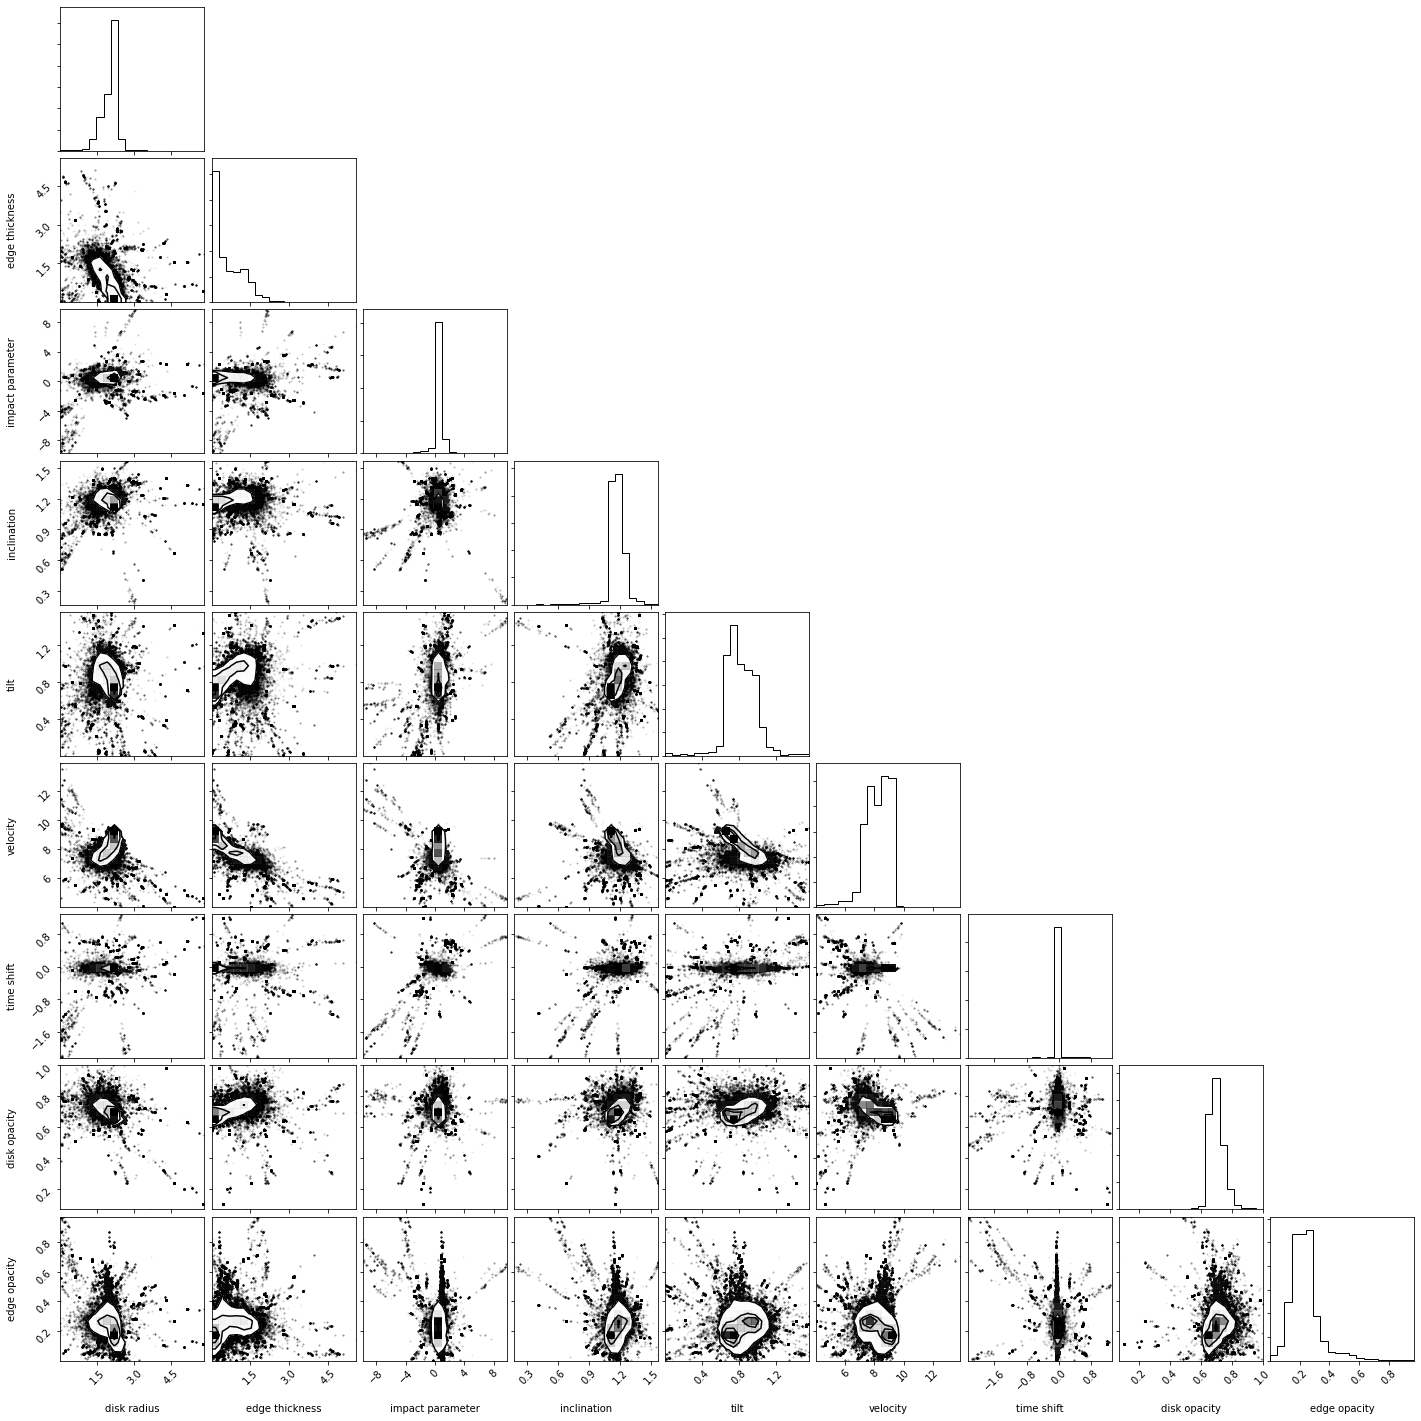

In [77]:
# plot the translucent triangle for the fuzzy disk
mcmc.plot_triangle(dol_fd, 0, lbls_fd)

Clearly one solution, so we observe this one too.

100%|██████████| 500/500 [01:34<00:00,  5.31it/s]


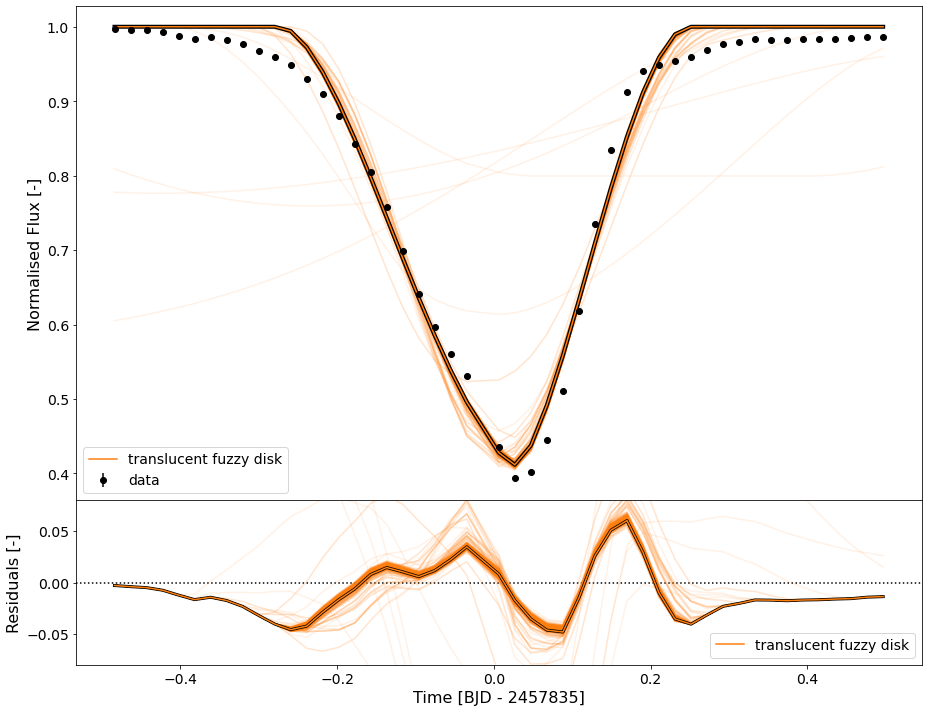

In [78]:
# determine burn-in for the translucent solutions for the fuzzy disk
cut_dol_fd = 350

# carry out statistics for the translucent solutions for the fuzzy disk
stats_dol_fd, pb_dol_fd = mcmc.stats(dol_fd, cut=cut_dol_fd)

# plot the samples for the translucent solutions for the fuzzy disk
_ = mcmc.plot_samples(time, flux, error, [fuzzy_disk], [dol_fd], ['translucent fuzzy disk'], cut_dol_fd, 500, 
                 best_fit=True, dt=3002, residual_lims=(-0.08,0.08))

In [79]:
# print the best fit parameters for the translucent solutions for the fuzzy disk
mcmc.print_parameters(pb_dol_fd, lbls_fd, units_fd)

disk radius        =     +2.248063     [R*]
edge thickness     =     +0.041985     [R*]
impact parameter   =     +0.866985     [R*]
inclination        =     +65.02804     [deg]
tilt               =     +40.11106     [deg]
velocity           =     +9.083532     [R*/day]
time shift         =     -0.062887     [day]
disk opacity       =     +0.671705     [-]
edge opacity       =     +0.168664     [-]


### Compare Fuzzy Disk Solutions

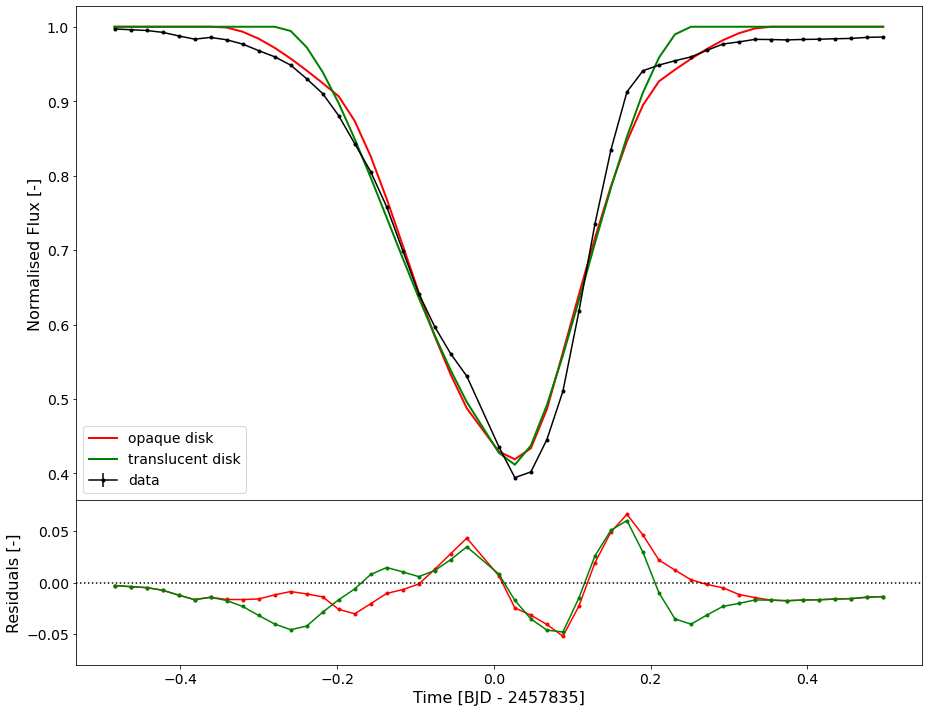

In [80]:
chi2s_fd = mcmc.plot_models(time, flux, error, 2*[fuzzy_disk], [pb_doh_fd, pb_dol_fd], 
                     ['opaque disk', 'translucent disk'], dt=3002, residual_lims=(-0.08, 0.08), lw=2)

In [81]:
print('chi2 for the fuzzy disk with an opaque disk is     - %.6f' % chi2s_fd[0])
print('chi2 for the fuzzy disk with a translucent disk is - %.6f' % chi2s_fd[1])

chi2 for the fuzzy disk with an opaque disk is     - 2041840.586499
chi2 for the fuzzy disk with a translucent disk is - 2577512.724554


In [85]:
# saving the best fit models for the fuzzy disks
np.save('models/best_fits/fuzzy_opaque_disk.npy', pb_doh_fd)
np.save('models/best_fits/fuzzy_translucent_disk.npy', pb_dol_fd)